# Importing libraries

In [1]:
import sys
sys.path.append('../../')

In [1]:
from pymc_marketing.mmm.models.hierarchical_delayed_saturated_mmm import (
    HierarchicalDelayedSaturatedMMM,
)

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import pymc as pm

import pytensor.tensor as pt

# Creating synth data

In [17]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [18]:
# Step 1: Initialize the DataFrame with Dates
start_date = '2020-01-01'
end_date = '2021-01-01'
dates = pd.date_range(start=start_date, end=end_date, freq='D')
df = pd.DataFrame({'date': np.tile(dates, 3)})  # Repeat dates for each hierarchy

# Step 2: Add Hierarchical Levels
hierarchies = ['Venezuela', 'Chile', 'Estonia']
hierarchy = hierarchies * len(dates)  # Repeat for each date
df['hierarchy'] = hierarchy

# Sorting to ensure dates are in order for each hierarchy
df = df.sort_values(by=['date', 'hierarchy']).reset_index(drop=True)

n = len(df)

## Creating variables with share baseline
Creating different variables for each hierarchie from the same baseline.

In [19]:
channels = ["facebook", "google", "tv"]

In [20]:
base_x1 = rng.uniform(low=0.0, high=5, size=n)
df['facebook'] = np.where(base_x1 > 3, base_x1, base_x1 / 3)
df['facebook'] = df.groupby('hierarchy')['facebook'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

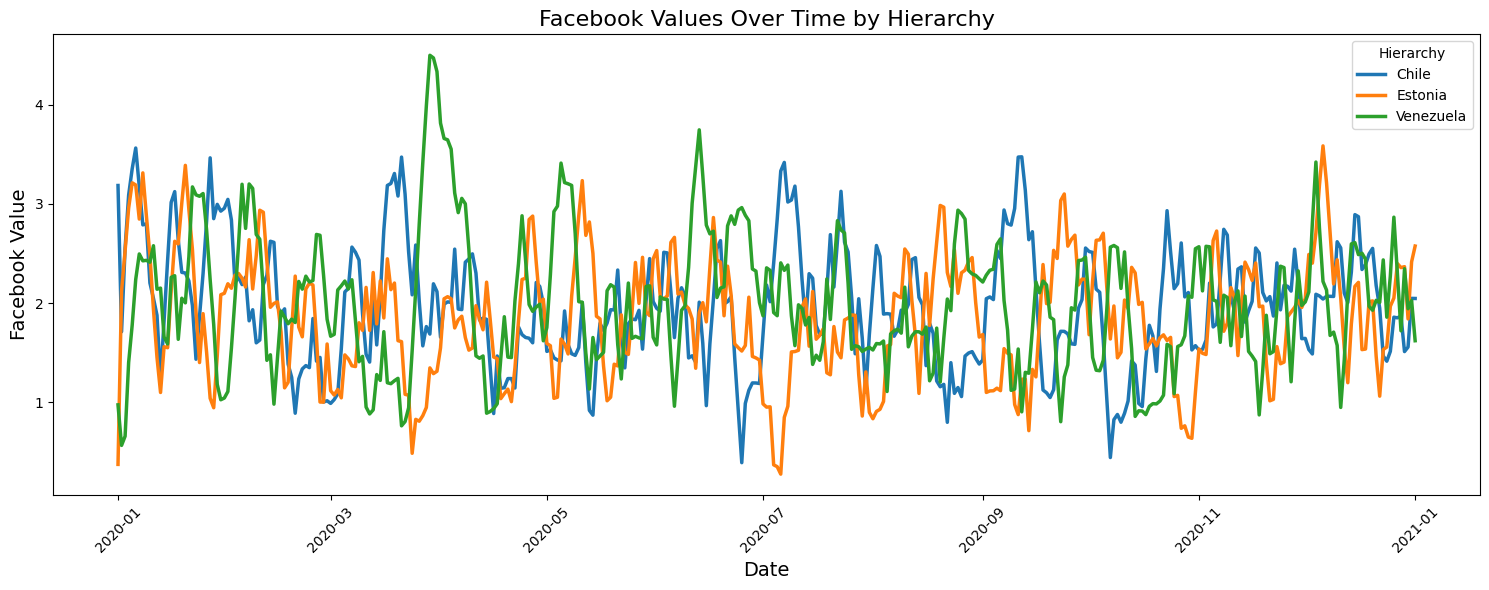

In [21]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='date', y='facebook', hue='hierarchy', palette='tab10', linewidth=2.5)

# Enhancing the plot
plt.title('Facebook Values Over Time by Hierarchy', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Facebook Value', fontsize=14)
plt.legend(title='Hierarchy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [22]:
base_x2 = rng.uniform(low=0.0, high=4, size=n)
df['google'] = np.where(base_x2 > 2, base_x2, base_x2 / 2)
df['google'] = df.groupby('hierarchy')['google'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

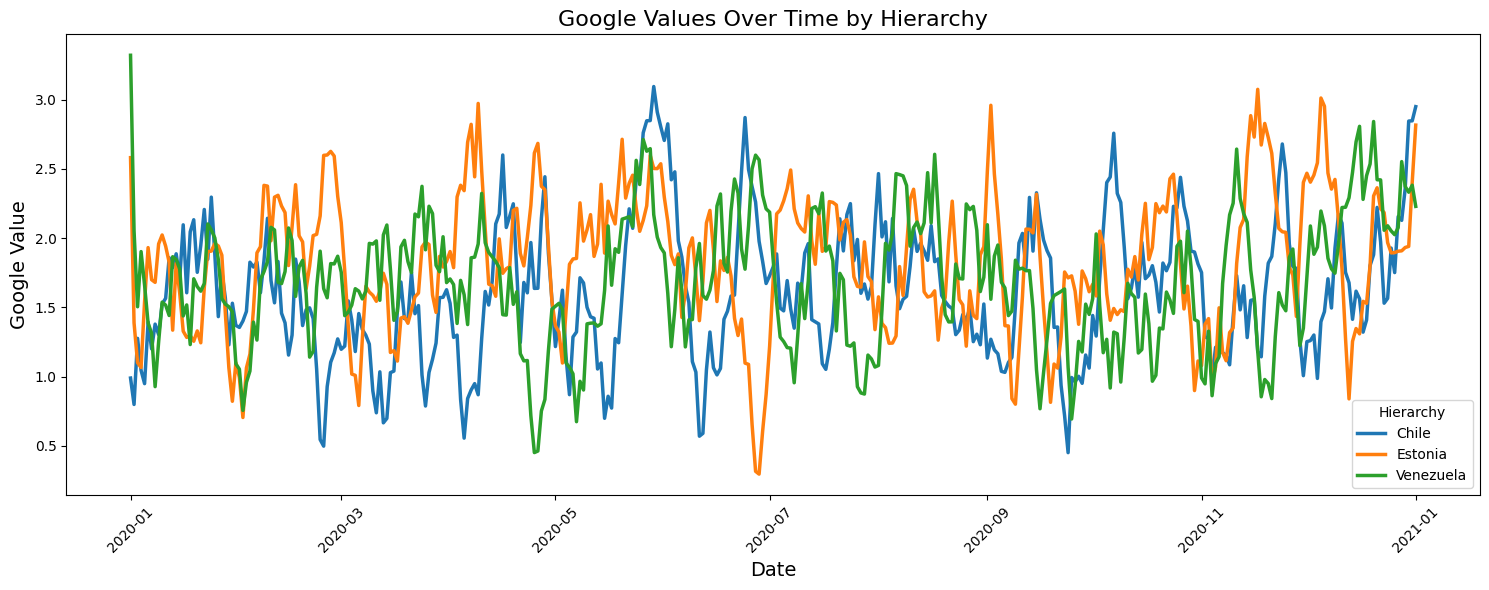

In [23]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='date', y='google', hue='hierarchy', palette='tab10', linewidth=2.5)

# Enhancing the plot
plt.title('Google Values Over Time by Hierarchy', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Google Value', fontsize=14)
plt.legend(title='Hierarchy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [24]:
base_x3 = rng.uniform(low=0.0, high=10, size=n)
base_x3 = np.where(base_x3 > 9.5, base_x3, 0)

# Initialize 'facebook' column with zeros as placeholder
df['tv'] = 0.0

# Step 2: Modify and Assign the 'TV' Data for Each Hierarchy with Correct Assignment
for h in hierarchy:
    # Generate a unique series of random zeroes for each hierarchy
    zeroes_mask = rng.uniform(0, 1, size=n) < 0.05  # 5% chance to be zero, adjust as needed
    
    # Apply modifications: select spikes for current hierarchy and assign
    hierarchy_indices = df['hierarchy'] == h
    modified_tv = np.where(zeroes_mask, 0, base_x3)  # Apply spikes selectively based on the mask
    
    # Correctly assigning 'tv' values for the current hierarchy
    df.loc[hierarchy_indices, 'tv'] = modified_tv[hierarchy_indices]

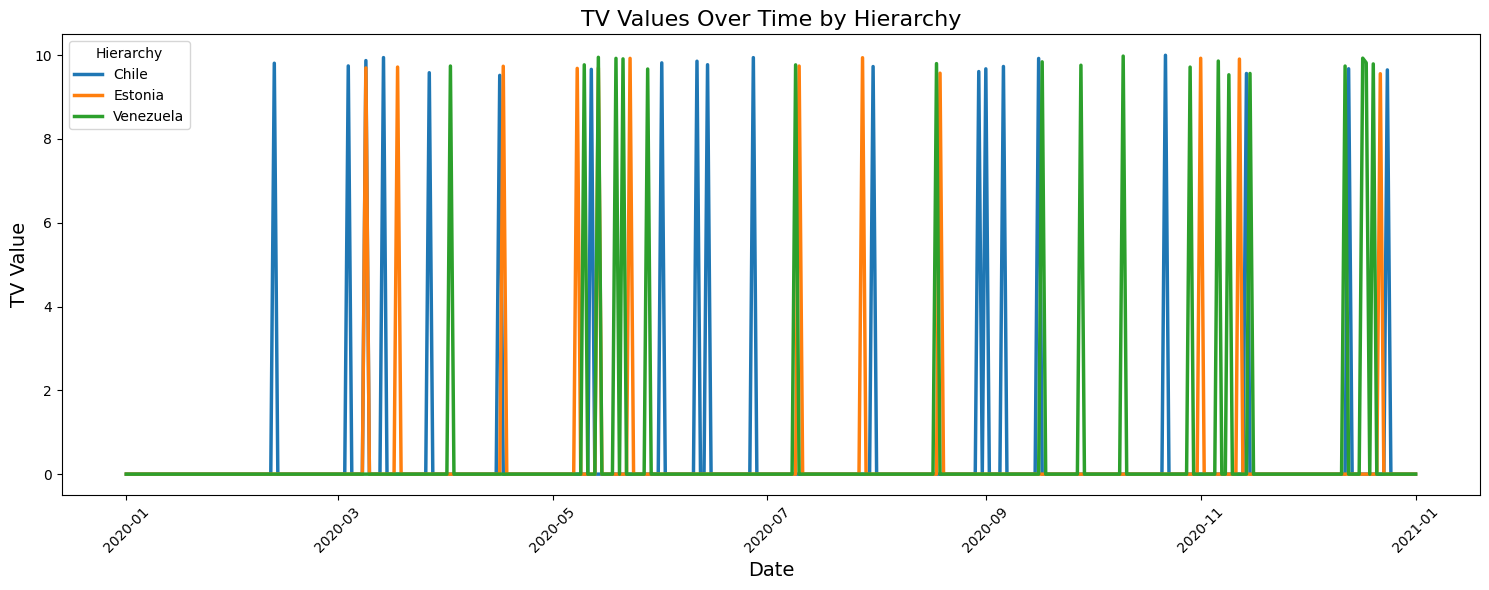

In [25]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='date', y='tv', hue='hierarchy', palette='tab10', linewidth=2.5)

# Enhancing the plot
plt.title('TV Values Over Time by Hierarchy', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('TV Value', fontsize=14)
plt.legend(title='Hierarchy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Creating seasonal components
- Same for all hierarchies

In [26]:
n_unique_dates = len(dates)

seasons = ["quarterly_seasonality", "yearly_seasonality"]
quarterly_seasonality = np.sin(2 * np.pi * np.arange(n_unique_dates) / 90)
yearly_seasonality = np.sin(2 * np.pi * np.arange(n_unique_dates) / 365)

# Repeat the patterns for each hierarchy level
df['quarterly_seasonality'] = np.tile(quarterly_seasonality, 3)  # Assuming 3 hierarchies
df['yearly_seasonality'] = np.tile(yearly_seasonality, 3)

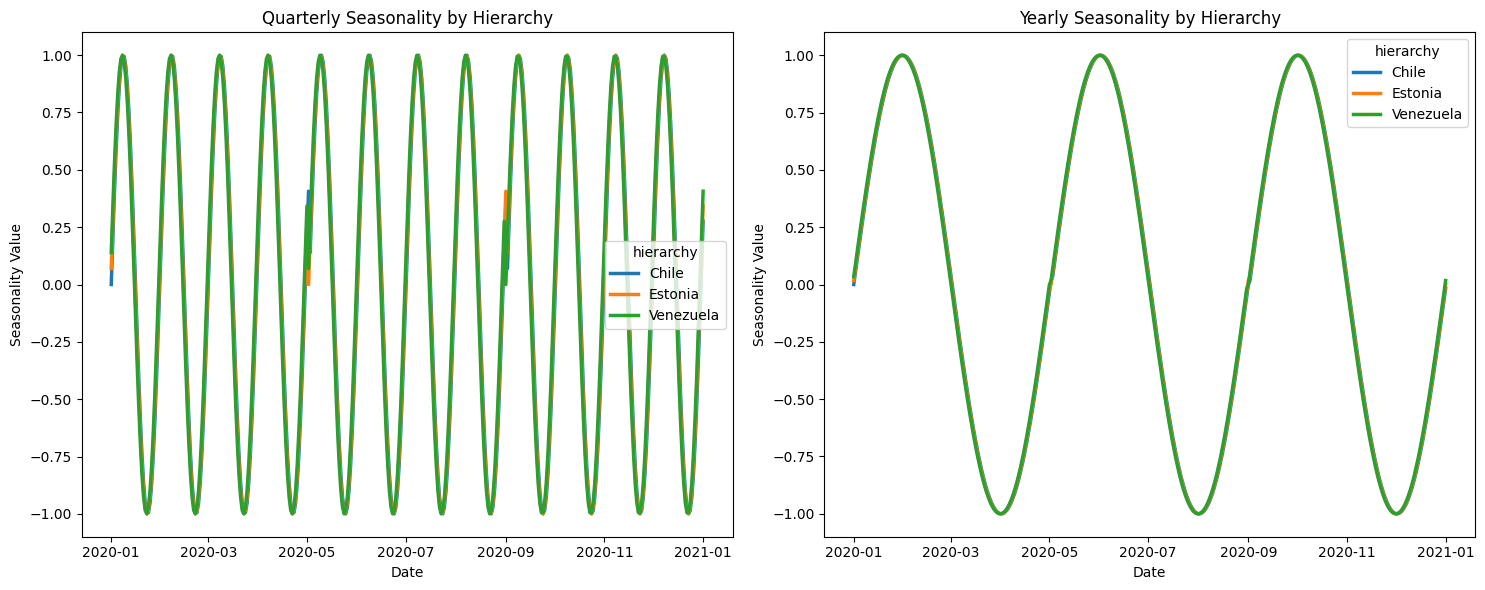

In [27]:
# Plotting
plt.figure(figsize=(15, 6))

# Quarterly seasonality
plt.subplot(1, 2, 1)
sns.lineplot(data=df, x='date', y='quarterly_seasonality', hue='hierarchy', palette='tab10', linewidth=2.5)
plt.title('Quarterly Seasonality by Hierarchy')
plt.xlabel('Date')
plt.ylabel('Seasonality Value')

# Yearly seasonality
plt.subplot(1, 2, 2)
sns.lineplot(data=df, x='date', y='yearly_seasonality', hue='hierarchy', palette='tab10', linewidth=2.5)
plt.title('Yearly Seasonality by Hierarchy')
plt.xlabel('Date')
plt.ylabel('Seasonality Value')

plt.tight_layout()
plt.show()

# Creating target variable

In [28]:
df['y'] = 1 * pt.ones(n).eval()
df.head()

,date,hierarchy,facebook,google,tv,quarterly_seasonality,yearly_seasonality,y
0,2020-01-01,Chile,3.185800,0.988924,0.0,0.000000,0.000000,1.0
1,2020-01-01,Estonia,0.374628,2.580742,0.0,0.069756,0.017213,1.0
2,2020-01-01,Venezuela,0.974668,3.320135,0.0,0.139173,0.034422,1.0
3,2020-01-02,Chile,1.711898,0.798520,0.0,0.207912,0.051620,1.0
4,2020-01-02,Estonia,2.121040,1.387268,0.0,0.275637,0.068802,1.0


In [29]:
dummy_model = HierarchicalDelayedSaturatedMMM(
    data = df,
    date_column = 'date',
    channel_columns = channels,
    control_columns= seasons,
    hierarchy_column = 'hierarchy',
    target_column = 'y',
    lagging_function = 'geometric',
    saturation_function  = 'michaelis_menten',
    adstock_max_lagging = 10
)

TypeError: Can't instantiate abstract class HierarchicalDelayedSaturatedMMM with abstract methods _data_setter, _generate_and_preprocess_model_data, _serializable_model_config, default_model_config, default_sampler_config, output_var